# Итоговый проект: Flight Delay
#### 1. Загрузка, обзор и подготовка данных;
#### 2. Найти аэропорт с минимальной задержкой вылета;
#### 3. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport;
#### 4. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение);
#### 5. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета.

<img src="https://www.scylladb.com/wp-content/uploads/flight-delay.jpg" width ="300" height=300 >
<table style="width:30%">
    <tr>
        <th>Выполнил:</th>
        <td>Иванов Д.И.</td>
    </tr>
    <tr>
        <th>Руководитель:</th>
        <td>Русских С.В.</td>
    </tr>
</table>

## Импорт библиотек


In [114]:
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# 1. Загрузка, обзор и подготовка данных

## Данные - https://www.kaggle.com/usdot/flight-delays

Описание - cводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)

<b>Описание столбцов:</b>

<b>YEAR:</b> Год полета<br>
<b>MONTH:</b> Месяц полета<br>
<b>DAY:</b> День полета<br>
<b>DAY_OF_WEEK:</b> День недели полета<br>
<b>AIRLINE:</b> Идентификатор авиакомпании<br>
<b>FLIGHT_NUMBER:</b> Идентификатор рейса<br>
<b>TAIL_NUMBER:</b> Идентификатор воздушного судна<br>
<b>ORIGIN_AIRPORT:</b> Начальный аэропорт<br>
<b>DESTINATION_AIRPORT:</b> Аэропорт назначения<br>
<b>SCHEDULED_DEPARTURE:</b> Запланированное Время Отправления<br>
<b>DEPARTURE_TIME:</b> WHEEL_OFF - TAXI_OUT<br>
<b>DEPARTURE_DELAY:</b> Общая задержка вылета<br>
<b>TAXI_OUT:</b> Продолжительность времени, прошедшего между вылетом из ворот аэропорта отправления и вылетом<br>
<b>WHEELS_OFF:</b> Момент времени, когда колеса самолета отрываются от земли<br>
<b>SCHEDULED_TIME:</b> Запланированное количество времени, необходимое для перелета<br>
<b>ELAPSED_TIME:</b> AIR_TIME + TAXI_IN + TAXI_OUT<br>
<b>AIR_TIME:</b> Продолжительность времени между wheels_off и wheels_on time<br>
<b>DISTANCE:</b> Расстояние между двумя аэропортами<br>
<b>WHEELS_ON:</b> Момент времени, когда колеса самолета касаются земли<br>
<b>TAXI_IN:</b> Продолжительность времени, прошедшего между включением колес и прибытием на посадку в аэропорту назначения<br>
<b>SCHEDULED_ARRIVAL:</b> Планируемое время прибытия<br>
<b>ARRIVAL_TIME:</b> WHEELS_ON + TAXI_IN<br>
<b>ARRIVAL_DELAY:</b> ARRIVAL_TIME - SCHEDULED_ARRIVAL<br>
<b>DIVERTED:</b> Самолет приземлился в аэропорту, который вышел из графика<br>
<b>CANCELLED:</b> Рейс отменен (1 = отменен)<br>
<b>CANCELLATION_REASON:</b> Причина отмены рейса: A - Авиакомпания/Перевозчик; B - Погода; C - Национальная воздушная система; D - Безопасность<br>
<b>AIR_SYSTEM_DELAY:</b> Delay caused by air system<br>
<b>SECURITY_DELAY:</b> Задержка, вызванная воздушной системой<br>
<b>AIRLINE_DELAY:</b> Задержка, вызванная авиакомпанией<br>
<b>LATE_AIRCRAFT_DELAY:</b> Задержка, вызванная самолетом<br>
<b>WEATHER_DELAY:</b> Задержка, вызванная погодными условиями<br>

In [51]:
flights = pd.read_csv('flights.csv', dtype={'ORIGIN_AIRPORT': str,'DESTINATION_AIRPORT': str })
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')

In [52]:
flights.head(3)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
airlines.head(3)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.


In [54]:
airports.head(3)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919


In [55]:
print(flights.info() ,airlines.info(),airports.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [56]:
flights.shape

(5819079, 31)

In [57]:
airlines.shape

(14, 2)

In [58]:
airports.shape

(322, 7)

In [59]:
flights.nunique()

YEAR                      1
MONTH                    12
DAY                      31
DAY_OF_WEEK               7
AIRLINE                  14
FLIGHT_NUMBER          6952
TAIL_NUMBER            4897
ORIGIN_AIRPORT          628
DESTINATION_AIRPORT     629
SCHEDULED_DEPARTURE    1321
DEPARTURE_TIME         1440
DEPARTURE_DELAY        1217
TAXI_OUT                184
WHEELS_OFF             1440
SCHEDULED_TIME          550
ELAPSED_TIME            712
AIR_TIME                675
DISTANCE               1363
WHEELS_ON              1440
TAXI_IN                 185
SCHEDULED_ARRIVAL      1435
ARRIVAL_TIME           1440
ARRIVAL_DELAY          1240
DIVERTED                  2
CANCELLED                 2
CANCELLATION_REASON       4
AIR_SYSTEM_DELAY        570
SECURITY_DELAY          154
AIRLINE_DELAY          1067
LATE_AIRCRAFT_DELAY     695
WEATHER_DELAY           632
dtype: int64

In [60]:
airlines.nunique()

IATA_CODE    14
AIRLINE      14
dtype: int64

In [61]:
airports.nunique()

IATA_CODE    322
AIRPORT      322
CITY         308
STATE         54
COUNTRY        1
LATITUDE     319
LONGITUDE    319
dtype: int64

In [62]:
flights.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [63]:
airlines.isnull().sum()

IATA_CODE    0
AIRLINE      0
dtype: int64

In [64]:
airports.isnull().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [65]:
flights.duplicated().sum()

0

In [66]:
airlines.duplicated().sum()

0

In [67]:
airports.duplicated().sum()

0

In [68]:
round(flights.describe(),3)

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5819079.000,5819079.000,5819079.000,5819079.000,5819079.000,5732926.000,5732926.000,5730032.000,5730032.000,...,5819079.000,5726566.000,5714008.000,5819079.000,5819079.000,1063439.000,1063439.000,1063439.000,1063439.000,1063439.000
mean,2015.0,6.524,15.705,3.927,2173.093,1329.602,1335.204,9.370,16.072,1357.171,...,1493.808,1476.491,4.407,0.003,0.015,13.481,0.076,18.970,23.473,2.915
std,0.0,3.405,8.783,1.989,1757.064,483.752,496.423,37.081,8.896,498.009,...,507.165,526.320,39.271,0.051,0.123,28.004,2.143,48.162,43.197,20.433
min,2015.0,1.000,1.000,1.000,1.000,1.000,1.000,-82.000,1.000,1.000,...,1.000,1.000,-87.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2015.0,4.000,8.000,2.000,730.000,917.000,921.000,-5.000,11.000,935.000,...,1110.000,1059.000,-13.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2015.0,7.000,16.000,4.000,1690.000,1325.000,1330.000,-2.000,14.000,1343.000,...,1520.000,1512.000,-5.000,0.000,0.000,2.000,0.000,2.000,3.000,0.000
75%,2015.0,9.000,23.000,6.000,3230.000,1730.000,1740.000,7.000,19.000,1754.000,...,1918.000,1917.000,8.000,0.000,0.000,18.000,0.000,19.000,29.000,0.000
max,2015.0,12.000,31.000,7.000,9855.000,2359.000,2400.000,1988.000,225.000,2400.000,...,2400.000,2400.000,1971.000,1.000,1.000,1134.000,573.000,1971.000,1331.000,1211.000


In [69]:
flights['dDate'] = pd.to_datetime(flights[['YEAR','MONTH','DAY']], dayfirst=True)

# 2. Найти аэропорт с минимальной задержкой вылета

In [70]:
flights = flights.merge(airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')
flights = flights.merge(airports, left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='inner')

In [71]:
flights = flights.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')
flights = flights.drop(['AIRLINE_x','IATA_CODE'], axis=1)
flights = flights.rename(columns={"AIRLINE_y":"AIRLINE"})

In [72]:
flights = flights.drop(['LATITUDE_x', 'LONGITUDE_x', 'STATE_y', 'COUNTRY_y', 
                        'LATITUDE_y', 'LONGITUDE_y','STATE_x', 'COUNTRY_x'], axis=1)

In [73]:
flights = flights.rename(columns={'IATA_CODE_x':'Orig_Airport_Code', 'AIRPORT_x':'Orig_Airport_Name',
                                  'CITY_x':'Origin_city', 'IATA_CODE_y':'Dest_Airport_Code',
                                  'AIRPORT_y':'Dest_Airport_Name', 'CITY_y':'Destination_city'})

In [74]:
df = flights.groupby('ORIGIN_AIRPORT').agg({'DEPARTURE_DELAY':'mean'}).sort_values('DEPARTURE_DELAY')
df.head(1)

,DEPARTURE_DELAY
ORIGIN_AIRPORT,
YAK,-6.292237


In [75]:
airports[airports['IATA_CODE']==df.head(1).index[0]]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


# 3. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

In [78]:
airlines = airlines.rename(columns={'AIRLINE': 'FULL_NAME_AIRLINE','IATA_CODE': 'AIRLINE'})
airlines

,AIRLINE,FULL_NAME_AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [81]:
flights = flights.rename(columns={'AIRLINE': 'FULL_NAME_AIRLINE'})
flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,dDate,Orig_Airport_Code,Orig_Airport_Name,Origin_city,Dest_Airport_Code,Dest_Airport_Name,Destination_city,FULL_NAME_AIRLINE
0,2015,1,1,4,98,N407AS,ANC,SEA,5,2354.0,...,NaN,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.
1,2015,1,1,4,108,N309AS,ANC,SEA,45,41.0,...,NaN,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.
2,2015,1,1,4,136,N431AS,ANC,SEA,135,NaN,...,NaN,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.
3,2015,1,1,4,134,N464AS,ANC,SEA,155,140.0,...,NaN,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.
4,2015,1,1,4,114,N303AS,ANC,SEA,220,209.0,...,NaN,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332909,2015,12,29,2,3450,N668MQ,MIA,GNV,2154,2150.0,...,NaN,NaN,2015-12-29,MIA,Miami International Airport,Miami,GNV,Gainesville Regional Airport,Gainesville,American Eagle Airlines Inc.
5332910,2015,12,30,3,3436,N674MQ,MIA,GNV,1540,1540.0,...,NaN,NaN,2015-12-30,MIA,Miami International Airport,Miami,GNV,Gainesville Regional Airport,Gainesville,American Eagle Airlines Inc.
5332911,2015,12,30,3,3450,N941MQ,MIA,GNV,2154,2149.0,...,NaN,NaN,2015-12-30,MIA,Miami International Airport,Miami,GNV,Gainesville Regional Airport,Gainesville,American Eagle Airlines Inc.
5332912,2015,12,31,4,3436,N941MQ,MIA,GNV,1540,1529.0,...,NaN,NaN,2015-12-31,MIA,Miami International Airport,Miami,GNV,Gainesville Regional Airport,Gainesville,American Eagle Airlines Inc.


In [82]:
df1= flights.merge(airlines, on = 'FULL_NAME_AIRLINE')
df1.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WEATHER_DELAY,dDate,Orig_Airport_Code,Orig_Airport_Name,Origin_city,Dest_Airport_Code,Dest_Airport_Name,Destination_city,FULL_NAME_AIRLINE,AIRLINE
0,2015,1,1,4,98,N407AS,ANC,SEA,5,2354.0,...,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.,AS
1,2015,1,1,4,108,N309AS,ANC,SEA,45,41.0,...,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.,AS
2,2015,1,1,4,136,N431AS,ANC,SEA,135,NaN,...,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.,AS
3,2015,1,1,4,134,N464AS,ANC,SEA,155,140.0,...,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.,AS
4,2015,1,1,4,114,N303AS,ANC,SEA,220,209.0,...,NaN,2015-01-01,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,Alaska Airlines Inc.,AS


In [83]:
airports[airports['AIRPORT'] == 'Los Angeles International Airport']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
176,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [84]:
df2 = df1[df1['DESTINATION_AIRPORT'] == 'LAX']

In [85]:
df2.groupby('FULL_NAME_AIRLINE', as_index = False).agg({'ARRIVAL_DELAY':'mean'}).sort_values('ARRIVAL_DELAY').head(1)

,FULL_NAME_AIRLINE,ARRIVAL_DELAY
5,Hawaiian Airlines Inc.,-4.668819


# 4. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [87]:
flights.sample(5).T

,3498235,667121,3470410,27904,4282613
YEAR,2015,2015,2015,2015,2015
MONTH,8,12,9,5,7
DAY,4,14,2,11,26
DAY_OF_WEEK,2,1,3,1,7
FLIGHT_NUMBER,705,1305,1463,31,306
TAIL_NUMBER,N920FR,N357NW,N912FR,N461AS,N484AA
ORIGIN_AIRPORT,ATL,BNA,LGA,PHL,DFW
DESTINATION_AIRPORT,MSY,DTW,ATL,SEA,IND
SCHEDULED_DEPARTURE,1905,1020,959,1800,802
DEPARTURE_TIME,1859,1019,944,1752,756


In [90]:
df3 = (flights.groupby(['ORIGIN_AIRPORT']).agg({'TAXI_OUT':'sum'})/flights.groupby(['ORIGIN_AIRPORT']).agg({'TAXI_OUT':'count'}))\
.sort_values('TAXI_OUT',ascending=False).head(1)
df3

,TAXI_OUT
ORIGIN_AIRPORT,
JFK,27.009783


In [92]:
airports[airports['IATA_CODE'] == df3.index[0]]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
166,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893


# 5. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

In [108]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.dDate.dt.year
    data['month'] = data.dDate.dt.month
    data['day'] = data.dDate.dt.day
    data['dayofweek'] = data.dDate.dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)
flights['dDate'] = pd.to_datetime(flights[['YEAR','MONTH', 'DAY']])

In [109]:
fg = flights.groupby(['dDate','DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].sum().reset_index()
flight_grouped['dDate'] = pd.to_datetime(flight_grouped['dDate'])

In [116]:
arrive_lr = []
arrive_xg = []

for dest in tqdm(flight_grouped.DESTINATION_AIRPORT.unique()):
    tempo = flight_grouped[flight_grouped.DESTINATION_AIRPORT==dest][['dDate','ARRIVAL_DELAY']]
    tempo.columns = ['dDate','ARRIVAL_DELAY']
    tempo = pd.DataFrame(tempo)
    try:
        make_features(tempo,21,7)
        tempo.dropna(inplace=True)
        tempo.set_index('dDate',inplace=True)
        tempo.drop('year', axis =1, inplace=True)
        X_train,X_test,y_train, y_test = train_test_split(tempo.drop(['ARRIVAL_DELAY'], axis=1),tempo.ARRIVAL_DELAY, shuffle=False, test_size=0.25)
                              
        model_lr = LinearRegression()
        model_lr.fit(X_train,y_train)
              
        xgb = XGBRegressor(n_estimators=500, max_depth=8, eta=0.1, subsample=0.5, colsample_bytree=0.5)
        xgb.fit(X_train, y_train)

        y_predicted_lr = model_lr.predict(X_test)
        y_predicted_xg = xgb.predict(X_test)

        arrive_lr.append([dest,y_test.mean(),np.sqrt(mean_squared_error(y_test, y_predicted_lr))])
        arrive_xg.append([dest,y_test.mean(),np.sqrt(mean_squared_error(y_test, y_predicted_xg))])

    except Exception as e:
        print('Error', str(e))

  0%|          | 0/322 [00:00<?, ?it/s]

In [119]:
arrive_lr = pd.DataFrame(arrive_lr)
arrive_lr.columns = ['DESTINATION_AIRPORT','MEAN_ARRIVAL_DELAY_IN_PAST','RMSE']
arrive_xg = pd.DataFrame(arrive_xg)
arrive_xg.columns = ['DESTINATION_AIRPORT','MEAN_ARRIVAL_DELAY_IN_PAST','RMSE']

In [128]:
d_airport = np.random.choice(flights['ORIGIN_AIRPORT'].unique())

arrive_from_d_airport = flights[flights.ORIGIN_AIRPORT==d_airport]['DESTINATION_AIRPORT'].unique()

arrive_from_d_airport = pd.DataFrame(arrive_from_d_airport)
arrive_from_d_airport.columns = ['DESTINATION_AIRPORT']

top3_lr = arrive_from_d_airport\
    .merge(arrive_lr,on='DESTINATION_AIRPORT',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_IN_PAST'],ascending=[True, True])\
    .head(3)
top3_xg = arrive_from_d_airport\
    .merge(arrive_xg,on='DESTINATION_AIRPORT',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_IN_PAST'],ascending=[True, True])\
    .head(3)

print('LinearRegression')
print('Лучшие направления с аэропорта',d_airport)
print('')
print(top3_lr)
print('')
print('XGBRegressor')
print('Лучшие направления с аэропорта',d_airport)
print('')
print(top3_xg)

LinearRegression
Лучшие направления с аэропорта CRP

  DESTINATION_AIRPORT  MEAN_ARRIVAL_DELAY_IN_PAST         RMSE
4                 HRL                   17.354430    96.592402
1                 HOU                   43.278481  1588.451624
0                 IAH                  711.075949  4725.023665

XGBRegressor
Лучшие направления с аэропорта CRP

  DESTINATION_AIRPORT  MEAN_ARRIVAL_DELAY_IN_PAST         RMSE
4                 HRL                   17.354430   104.827614
1                 HOU                   43.278481  1630.205604
0                 IAH                  711.075949  5120.333218


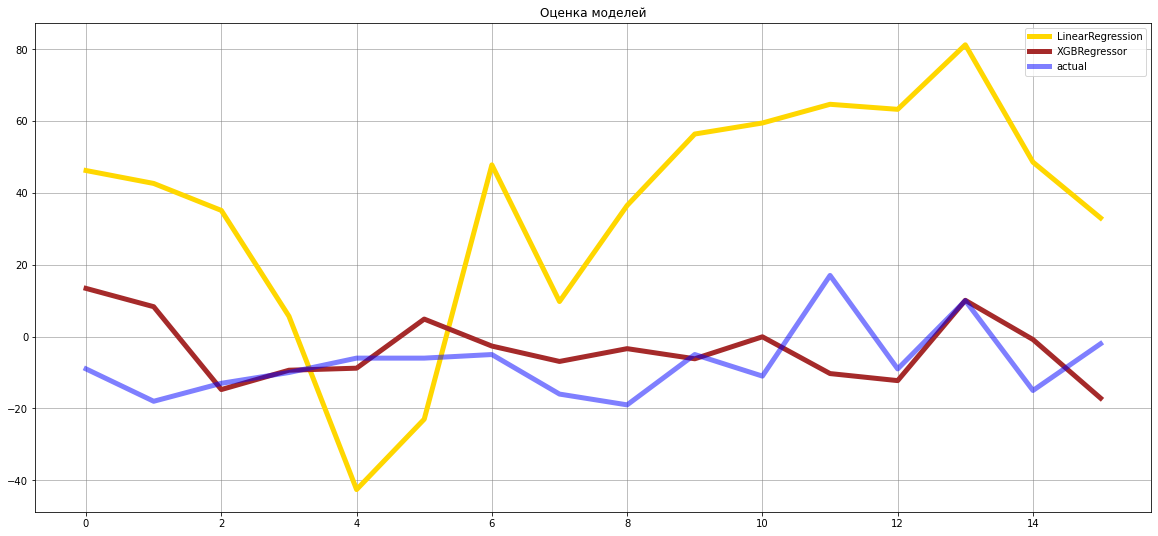

In [160]:
plt.figure(figsize=(20, 9))
plt.plot(y_predicted_lr, "gold",linewidth=5, label="LinearRegression")
plt.plot(y_predicted_xg, "brown",linewidth=5, label="XGBRegressor")
plt.plot(y_test.values,'blue' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(color = 'gray',
        linewidth = 0.5,
        linestyle = '-');

In [134]:
result_df = pd.DataFrame([[arrive_lr.RMSE.min(), arrive_xg.RMSE.min()],
                         [arrive_lr.RMSE.max(), arrive_xg.RMSE.max()],
                         [arrive_lr.RMSE.mean(), arrive_xg.RMSE.mean()]],
                        columns = ['LinearRegression','XGBRegressor'], index=['RMSE min', ' RMSE max', 'RMSE mean'])
round(result_df,2)

,LinearRegression,XGBRegressor
RMSE min,9.40,4.23
RMSE max,15112.15,18437.21
RMSE mean,533.43,579.38
